Juan de Dios Romero Palop


AFI - Master en Data Science y Big Data


12/05/22

# Entendiendo Lime y sus funcionalidades

[Artículo original](http://www.kdd.org/kdd2016/papers/files/rfp0573-ribeiroA.pdf) 

[Libro](https://christophm.github.io/interpretable-ml-book/lime.html)

[Repositorio](https://github.com/marcotcr/lime).

[Más info sobre shap](https://towardsdatascience.com/explain-your-model-with-the-shap-values-bc36aac4de3d).

In [3]:
from __future__ import print_function
import numpy as np
import pandas as pd


import matplotlib.pyplot as plt
%matplotlib inline

# !pip install lime

import lime
import lime.lime_tabular

## 1. Conjunto sintético linealmente separable

 Creamos un dataset linealmente separable con dos variables explicativas y varias que no aportan nada para aplicar LIME. 

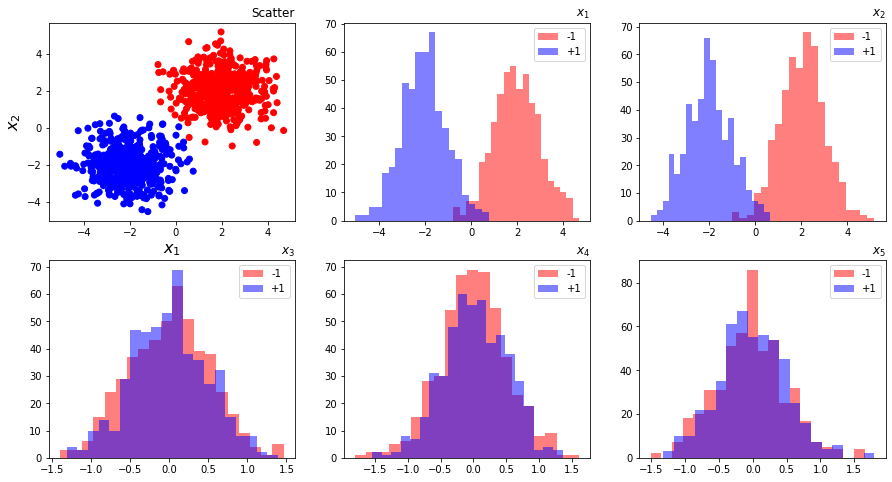

In [4]:
np.random.seed(0)

N     = 1000
mu    = 2      
sigma = 1      
n_noise_vars = 20

N_2 = int(N/2)
y = np.concatenate([-1*np.ones(N_2, dtype=int),np.ones(N_2, dtype=int)])

X1 = np.concatenate([ mu + sigma*np.random.randn(N_2,1),-mu + sigma*np.random.randn(N_2,1)])
X2 = np.concatenate([ mu + sigma*np.random.randn(N_2,1),-mu + sigma*np.random.randn(N_2,1)])

E  = 0.5*np.random.randn(N, n_noise_vars)
X  = np.hstack((X1,X2,E))

plt.figure(figsize=(15, 8))
plt.subplot(2, 3, 1)

plt.scatter(X1,X2, c = y.reshape(-1, 1), cmap='bwr_r')
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$x_2$", fontsize=16)
plt.title("Scatter", loc='right')

for i in range(5):
    plt.subplot(2, 3, i + 2)
    plt.hist(X[y<0,i],bins=20,  alpha=0.5, label='-1',color='r')
    plt.hist(X[y>0,i], bins=20, alpha=0.5, label='+1',color='b')
    plt.legend(loc='upper right')
    plt.title("$x_{}$".format(i + 1), loc='right')

plt.show()

feature_names = ['x' + str(i) for i in range(1,2+n_noise_vars+1)]

## 2. Ajustando el modelo

LIME busca explicar el comportamiento de un modelo en un entorno local. Vamos a utilizar una regresión logística como ejemplo.


In [5]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# reordenamos las muestras.
idx = np.random.permutation(range(len(y)))
X = X[idx,:]
y = y[idx]

# separamos en entrenamiento y test
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.30, random_state = 0)

# entrenamos el modelo (Logistic regression) y predecimos
lr = LogisticRegression(random_state=0)
lr.fit(X_train, y_train)
y_hat_lr = lr.predict(X_test)

# Resultados
print('Train Acc: {:0.4f}'.format(lr.score(X_train,y_train)))
print('Test  Acc: {:0.4f}'.format(lr.score(X_train,y_train)))

Train Acc: 1.0000
Test  Acc: 1.0000


## 3. LIME

 LIME realiza los siguientes pasos a la hora de aproximar modelos:
1. Se entrena un modelo, generalmente de caja negra, con todas las muestras del conjunto de entrenamiento. El modelo de caja-negra a utilizar está restringido a modelos que devuelven una probabilidad. Así, pueden utilizarse modelos como *random forest*, *boosted trees* o *regresión logística*. LIME toma el resultado del modelo, pero no entrena este modelo, así que ha de hacerse antes de llamar a la librería.
2. Se selecciona la instancia sobre la que se desea conocer sus explicaciones.
3. Se genera un nuevo conjunto de datos, en la vecindad local de la instancia, a partir perturbaciones sobre la misma.
4. Sobre este nuevo conjunto de datos, LIME entrena un modelo interpretable donde las muestras se ponderan por su distancia a la instancia original. 
5. Se utiliza este modelo interpretable para explicar las predicciones sobre la instancia seleccionada. 

En la versión actual de LIME para python, utiliza como modelo interpretable por defecto el algoritmo Regresión Lineal Ridge, el cual se entrena para ajustar la probabilidad predicha por el modelo de caja-negra sobre las muestras perturbadas. Los coeficientes de este modelo determinan las explicaciones de LIME.

LIME se puede utilizar con imágenes, texto y con datos almacendados en tablas (*tabular data*). Nos centraremos, nos centraremos en este último caso de uso, donde los datos pueden ser de naturaleza numérica o categórica.

A continuación describiremos los distintos parámetros que LIME utiliza para llevar a cabo las distintas operaciones.



## 4.  *Explainer*

Explainer es la clase de LIME donde se definen las condiciones para generar las explicaciones (el código puede consultarse [aquí](https://github.com/marcotcr/lime/blob/master/lime/lime_tabular.py), función ```LimeTabularExplainer```
). 

Veamos un ejemplo de como utilizar LIME para realizar una explicación sobre una muestra y qué podemos esperar de una explicación ofrecida por este método. Para ello declaramos un objeto de la clase `Explainer` y utilizamos el método `explain_instance` sobre la muestra que busquemos explicar. Éste método tiene diferentes parámetros que iremos explorando en este Notebook para entender como refinar las explicaciones.


In [6]:
# Creamos un explainer
explainer = lime.lime_tabular.LimeTabularExplainer(X_train, training_labels = y_train, 
                                                   feature_names = feature_names, 
                                                   class_names = ['rojo','azul'])

C:\Users\Javier\AppData\Local\Temp\ipykernel_10424\3833051856.py:13: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "r*" (-> marker='*'). The keyword argument will take precedence.
  plt.plot(X_test[id,0],X_test[id,1], color, markersize = 20,marker='*', label = 'instancia')


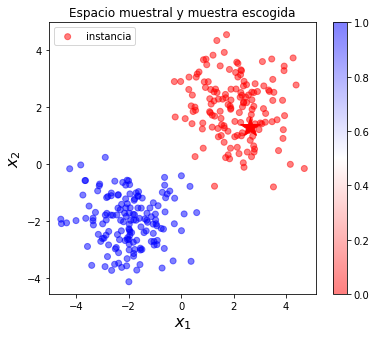

In [7]:
# Cogemos un punto aleatorio para estudiar
id = 40 

# Color de la clase
if y_test[id]==1:
    color = 'b*'
else:
    color = 'r*'

# Scatter plot de la clase
plt.figure(figsize=(6, 5))
plt.scatter(X_test[:,0],X_test[:,1],alpha = 0.5,c = y_test, cmap='bwr_r')
plt.plot(X_test[id,0],X_test[id,1], color, markersize = 20,marker='*', label = 'instancia')
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$x_2$", fontsize=16)
plt.title('Espacio muestral y muestra escogida')
plt.clim(0,1)
plt.colorbar()
plt.legend(['instancia'], loc='upper left')
plt.show()

[Manual](https://lime-ml.readthedocs.io/en/latest/lime.html#module-lime.lime_tabular)

In [8]:
# Ajustamos la explicación al punto de interés

explanation = explainer.explain_instance(X_test[id], lr.predict_proba, num_features=22)

# Comportamiento del modelo
print('Real Label: ', y_test[id])
print('Pred Label: ', y_hat_lr[id])
print('Expl. score:', explanation.score)

# Herramienta de visualización de LIME
explanation.show_in_notebook(show_all=True)

Real Label:  -1
Pred Label:  -1
Expl. score: 0.24892567414517075


La puntación de la explicación es el $R^2$ de la regresión lineal ajustada para predecir la probabilidad del modelo original. La puntuación no es muy alta, pero podría considerarse suficiente (Según un comentario en [StackExchange CrossValidated](https://stats.stackexchange.com/questions/330114) en la práctica es muy difícil obtener puntuaciones por encima de 0.5)

Las variables que explican el ejemplo son nuestras variables relevantes $x_1$ y $x_2$. LIME intuye correctamente lo que está pasando. 

Veamos a continuación qué parámetros podemos encontrar en la clase `Explainer` que puedan resultar de interés para el análisis.

## 4.1. Discretize_continuous

Uno de los parámetros más interesantes de la clase `Explainer` es `discretize_continuous`, donde se define cómo generar las muestras perturbadas de una instancia:

Así, 

* Si se selecciona `discretize_continuous = True` (opción por defecto), las variables numéricas serán discretizadas.   Las muestras sintéticas se generan muestreando una normal $N(\mu,\sigma)$ utilizando las medias y desviaciones estándar de cada una de las clases.
* Si se selecciona `discretize_continuous = False` las variables no son discretizadas y las muestras se generarán a través de una normal $N(\mu,\sigma)$ con $\mu=0$ y $\sigma=1$

Declaremos dos objetos para ver el comportamiento de este parámetro.

In [9]:
# Creamos un explainer sin discretizar
explainer_continuous = lime.lime_tabular.LimeTabularExplainer(X_train, training_labels = y_train, 
                                                   feature_names = feature_names, 
                                                   class_names = ['rojo','azul'],
                                                   discretize_continuous=False)

# Creamos un explainer discretizado
explainer_discretized = lime.lime_tabular.LimeTabularExplainer(X_train, training_labels = y_train, 
                                                   feature_names = feature_names, 
                                                   class_names = ['rojo','azul'],
                                                   discretize_continuous=True,
                                                   discretizer='decile')

Hemos instanciado dos objetos de la clase Explainer:
* `explainer_continuous`: Este objeto no discretizará la entrada 
* `explainer_discretized`: Este objeto sí discretiza la entrada por deciles.

Comprobemos ahora la diferencia a la hora de generar una nube de puntos sintéticos de los dos objetos declarados. LIME no tiene un método nativo para recuperar los datos sintéticos que se utilizan a la hora de generar la muestra en la vecindad de la instancia a explicar. `_LimeTabularExplainer__data_inverse` nos devuelve el conjunto de puntos, pero normalizado internamente por la clase. Deshacemos la normalización.



C:\Users\Javier\AppData\Local\Temp\ipykernel_10424\3074836167.py:16: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "r*" (-> marker='*'). The keyword argument will take precedence.
  plt.plot(X_test[id,0],X_test[id,1], color, markersize = 20,marker='*')
C:\Users\Javier\AppData\Local\Temp\ipykernel_10424\3074836167.py:31: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "r*" (-> marker='*'). The keyword argument will take precedence.
  plt.plot(X_test[id,0],X_test[id,1], color, markersize = 20,marker='*')


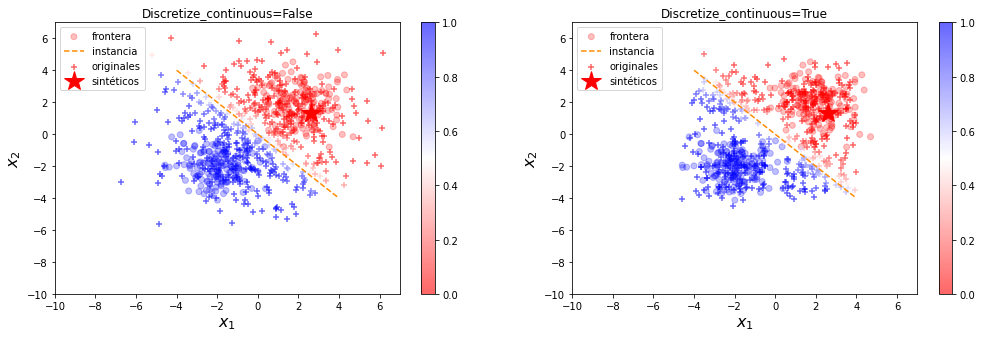

In [10]:
# Ajustamos la explicación al punto de interés
explanation_continuous = explainer_continuous.explain_instance(X_test[id], lr.predict_proba, num_features=22)
explanation_discrete = explainer_discretized.explain_instance(X_test[id], lr.predict_proba, num_features=22)

# Instancias perturbadas alrededor de la muestra por el discretizador continuo
data_c, inverse_c = explainer_continuous._LimeTabularExplainer__data_inverse(X_test[id],500)
# Instancias perturbadas alrededor de la muestra por el discretizador discreto
data_d, inverse_d = explainer_discretized._LimeTabularExplainer__data_inverse(X_test[id],500)

# Scatter del modelo continuo
plt.figure(figsize=(17, 5))
plt.subplot(1, 2, 1)
plt.scatter(X_test[:,0],X_test[:,1],alpha = 0.25,c = y_test, cmap='bwr_r')
plt.plot([-4,4],[4,-4],linestyle='--',color='DarkOrange')
plt.scatter(inverse_c[:,0],inverse_c[:,1],alpha = 0.6,c=lr.predict_proba(inverse_c)[:,1],marker='+', facecolors='none', cmap='bwr_r')
plt.plot(X_test[id,0],X_test[id,1], color, markersize = 20,marker='*')
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$x_2$", fontsize=16)
plt.title('Discretize_continuous=False')
plt.clim(0,1)
plt.xlim(-10,7)
plt.ylim(-10,7)
plt.colorbar()
plt.legend(['frontera','instancia','originales','sintéticos'], loc='upper left')

# Scatter del modelo discreto
plt.subplot(1, 2, 2)
plt.scatter(X_test[:,0],X_test[:,1],alpha = 0.25,c = y_test, cmap='bwr_r')
plt.plot([-4,4],[4,-4],linestyle='--',color='DarkOrange')
plt.scatter(inverse_d[:,0],inverse_d[:,1],alpha = 0.6,c=lr.predict_proba(inverse_d)[:,1],marker='+', facecolors='none', cmap='bwr_r')
plt.plot(X_test[id,0],X_test[id,1], color, markersize = 20,marker='*')
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$x_2$", fontsize=16)
plt.title('Discretize_continuous=True')
plt.clim(0,1)
plt.xlim(-10,7)
plt.ylim(-10,7)
plt.colorbar()
plt.legend(['frontera','instancia','originales','sintéticos'], loc='upper left')
plt.show()

Vemos el efecto del discretizador aplicado sobre la generación de muestras perturbadas. La distribución de las muestras generadas  por el *explainer* que no discretiza se halla mucho más disperso por el espacio muestral que las elaboradas por el *explainer* que discretiza. 

Sin embargo, las muestras discretizadas generadas son menos homogéneas. Podemos incluso intuir fronteras entre regiones de puntos muestreados sintéticamente. Las muestras han salido de muestrear cada uno de los deciles que dividen las variables, así que es comprensible que se aprecien pequeños clusters en el espacio muestral.

## 4.2. Sample_around_instance 

Si se selecciona `discretize_continuous = False`, no se discretizan las variables numéricas, y para generar las perturbaciones, existen dos alternativas modulables a través del parámetro `sample_around_instance`:

* `sample_around_instance = True`, se generan perturbaciones de acuerdo a una distribución normal, centrada en la instancia y con desviación típica la unidad.
    
* `sample_around_instance = False`, se perturbaciones de acuerdo a una distribución normal, centrada en el valor medio (centroide) de todas las observaciones y con desviación típica la unidad.

De este modo, tanto si se discretiza como si `sample_around_instance = False` las perturbaciones pueden no estar realmente en una vecindad de la instancia original. 

No obstante, posteriormente las perturbaciones se ponderan por su distancia a la observación original. Esto mitiga en parte el problema, pero para el caso discretizado la distancia se calcula después de discretizar, por lo que sólo se tiene en cuenta clases iguales o clases distintas (i.e. hay la misma distancia entre dos cuartiles cualesquiera y entre dos observaciones cualesquiera en esos cuartiles).

In [11]:

# Creamos un explainer centrado en instancia
explainer_instance = lime.lime_tabular.LimeTabularExplainer(X_train, training_labels = y_train, 
                                                   feature_names = feature_names, 
                                                   class_names = ['rojo','azul'],
                                                   discretize_continuous=False,
                                                   sample_around_instance=True)


# Creamos un explainer centrado en centroide
explainer_centroid = lime.lime_tabular.LimeTabularExplainer(X_train, training_labels = y_train, 
                                                   feature_names = feature_names, 
                                                   class_names = ['rojo','azul'],
                                                   discretize_continuous=False,
                                                   sample_around_instance=False)

Hemos instanciado dos objetos de la clase Explainer:
* `explainer_instance`: Este objeto está centrado en la instancia
* `explainer_centroid`: Este objeto está centrado en el centroide

Es turno de ver cómo se comporta `sample_around_instance` cuando no discretizamos las variables del dataset.

C:\Users\Javier\AppData\Local\Temp\ipykernel_10424\1226524437.py:15: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "r*" (-> marker='*'). The keyword argument will take precedence.
  plt.plot(X_test[id,0],X_test[id,1], color, markersize = 20,marker='*')
C:\Users\Javier\AppData\Local\Temp\ipykernel_10424\1226524437.py:30: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "r*" (-> marker='*'). The keyword argument will take precedence.
  plt.plot(X_test[id,0],X_test[id,1], color, markersize = 20,marker='*')


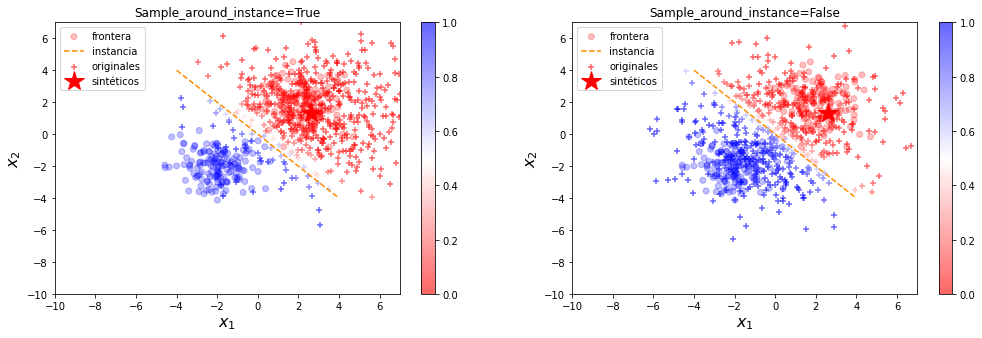

In [12]:
# Ajustamos la explicación al punto de interés
explanation_instance = explainer_instance.explain_instance(X_test[id], lr.predict_proba, num_features=22)
explanation_centroid = explainer_centroid.explain_instance(X_test[id], lr.predict_proba, num_features=22)

# Recuperamos los datos para su visualización
data_i, inverse_i = explainer_instance._LimeTabularExplainer__data_inverse(X_test[id],500)
data_ct, inverse_ct = explainer_centroid._LimeTabularExplainer__data_inverse(X_test[id],500)

# Scatter del modelo continuo
plt.figure(figsize=(17, 5))
plt.subplot(1, 2, 1)
plt.scatter(X_test[:,0],X_test[:,1],alpha = 0.25,c = y_test, cmap='bwr_r')
plt.plot([-4,4],[4,-4],linestyle='--',color='DarkOrange')
plt.scatter(inverse_i[:,0],inverse_i[:,1],alpha = 0.6,c=lr.predict_proba(inverse_i)[:,1],marker='+', facecolors='none', cmap='bwr_r')
plt.plot(X_test[id,0],X_test[id,1], color, markersize = 20,marker='*')
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$x_2$", fontsize=16)
plt.title('Sample_around_instance=True')
plt.clim(0,1)
plt.xlim(-10,7)
plt.ylim(-10,7)
plt.legend(['frontera','instancia','originales','sintéticos'], loc='upper left')
plt.colorbar()

# Scatter del modelo discreto
plt.subplot(1, 2, 2)
plt.scatter(X_test[:,0],X_test[:,1],alpha = 0.25,c = y_test, cmap='bwr_r')
plt.plot([-4,4],[4,-4],linestyle='--',color='DarkOrange')
plt.scatter(inverse_ct[:,0],inverse_ct[:,1],alpha = 0.6,c=lr.predict_proba(inverse_ct)[:,1],marker='+', facecolors='none', cmap='bwr_r')
plt.plot(X_test[id,0],X_test[id,1], color, markersize = 20,marker='*')
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$x_2$", fontsize=16)
plt.title('Sample_around_instance=False')
plt.clim(0,1)
plt.xlim(-10,7)
plt.ylim(-10,7)
plt.colorbar()
plt.legend(['frontera','instancia','originales','sintéticos'], loc='upper left')
plt.show()

Vemos de una forma clara el efecto que `sample_around_instance` tiene sobre las muestras perturbadas generadas. Cuando la variable es True, las muestras sintéticas se generan en el entorno de la muestra y corremos el peligro de no muestrear suficientes evidencias de clases alternativas.

Por otro lado, si el parámetro es False, las muestras generadas están centradas en el centroide, asegurándonos el muestreo de varias clases de interés. Sin embargo, estas nuevas muestras pueden no pertenecer al entorno local de la muestra a explicar y por tanto, no tener suficiente validez.

En el caso del ejemplo, como el punto a estudiar se encuentra en el exterior del clúster de la clase azul, las muestras generadas se hallan en un espacio no explorado por el clasificador.

## 4.3. Kernel width

`kernel_width` es el último de los parámetros de la clase `Explainer` que estudiaremos. Esta variable nos permite pesar las muestras perturbadas de acuerdo a la distancia existente entre cada muestra perturbada y la muestra de interés. De esta manera, a pesar de que cuando `discretize_continuous=True` o `sample_around_instance=False` generen puntos situados lejos de la instancia estudiada, podemos valorar la importancia de estar cerca de la misma.

El argumento `kernel_width` del método `lime.lime_tabular.LimeTabularExplainer()` representa el ancho del kernel exponencial que se utiliza para ponderar las perturbaciones por su distancia a la observación a explicar.
* Anchos demasiado pequeños no permiten al clasificador sencillo (explicación) aprender nada.
* Anchos demasiado grandes pueden hacer que la variable respuesta (probabilidad del modelo original) presente comportamientos no lineales que no puedan ser aprendidos por la explicación.

In [13]:
# Kernel_width = 1
explainer_kw_1 = lime.lime_tabular.LimeTabularExplainer(X_train, training_labels = y_train, 
                                                       feature_names = feature_names, 
                                                       class_names = ['rojo','azul'],
                                                       kernel_width=1,
                                                       discretize_continuous=False,
                                                       sample_around_instance=False)

# Kernel_width = 5
explainer_kw_5 = lime.lime_tabular.LimeTabularExplainer(X_train, training_labels = y_train, 
                                                       feature_names = feature_names, 
                                                       class_names = ['rojo','azul'],
                                                       kernel_width=5,
                                                       discretize_continuous=False,
                                                       sample_around_instance=False)

# Kernel_width = 10
explainer_kw_10 = lime.lime_tabular.LimeTabularExplainer(X_train, training_labels = y_train, 
                                                       feature_names = feature_names, 
                                                       class_names = ['rojo','azul'],
                                                       kernel_width=10,
                                                       discretize_continuous=False,
                                                       sample_around_instance=False)

# Kernel_width = 50
explainer_kw_50 = lime.lime_tabular.LimeTabularExplainer(X_train, training_labels = y_train, 
                                                       feature_names = feature_names, 
                                                       class_names = ['rojo','azul'],
                                                       kernel_width=50,
                                                       discretize_continuous=False,
                                                       sample_around_instance=False)

Creamos cuatro nuevos *explainers*, todos ellos sin discretización y centrados en centroide:
* `explainer_kw_1`: kernel width es 1
* ` explainer_kw_5`: kernel width es 5
* `explainer_kw_10`: kernel width es 10
* `explainer_kw_50`: kernel width es 50

Vamos a ver cómo pesa el kernel las distintas muestras perturbadas.

In [14]:
from sklearn.metrics.pairwise import euclidean_distances

# Ajustamos la explicación al punto de interés
explanation_kw_1 = explainer_kw_1.explain_instance(X_test[id], lr.predict_proba, num_features=22)
explanation_kw_5 = explainer_kw_5.explain_instance(X_test[id], lr.predict_proba, num_features=22)
explanation_kw_10 = explainer_kw_10.explain_instance(X_test[id], lr.predict_proba, num_features=22)
explanation_kw_50 = explainer_kw_50.explain_instance(X_test[id], lr.predict_proba, num_features=22)

# Recuperamos los datos para su visualización
data_1, inverse_1 = explainer_kw_1._LimeTabularExplainer__data_inverse(X_test[id],500)
data_5, inverse_5 = explainer_kw_5._LimeTabularExplainer__data_inverse(X_test[id],500)
data_10, inverse_10 = explainer_kw_10._LimeTabularExplainer__data_inverse(X_test[id],500)
data_50, inverse_50 = explainer_kw_50._LimeTabularExplainer__data_inverse(X_test[id],500)

# Distance to the points
distances_1 = euclidean_distances(X_test[id].reshape(1,-1), inverse_1)
distances_5 = euclidean_distances(X_test[id].reshape(1,-1), inverse_5)
distances_10 = euclidean_distances(X_test[id].reshape(1,-1), inverse_10)
distances_50 = euclidean_distances(X_test[id].reshape(1,-1), inverse_50)

# Aplicamos el kernel
weights_1 = np.sqrt(np.exp(-(distances_1 ** 2) / 1** 2))
weights_5 = np.sqrt(np.exp(-(distances_5 ** 2) / 5** 2))
weights_10 = np.sqrt(np.exp(-(distances_10 ** 2) / 10** 2))
weights_50 = np.sqrt(np.exp(-(distances_50 ** 2) / 50** 2))

C:\Users\Javier\AppData\Local\Temp\ipykernel_10424\1893862319.py:6: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "r*" (-> marker='*'). The keyword argument will take precedence.
  plt.plot(X_test[id,0],X_test[id,1], color, markersize = 20,marker='*')
C:\Users\Javier\AppData\Local\Temp\ipykernel_10424\1893862319.py:19: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "r*" (-> marker='*'). The keyword argument will take precedence.
  plt.plot(X_test[id,0],X_test[id,1], color, markersize = 20,marker='*')
C:\Users\Javier\AppData\Local\Temp\ipykernel_10424\1893862319.py:32: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "r*" (-> marker='*'). The keyword argument will take precedence.
  plt.plot(X_test[id,0],X_test[id,1], color, markersize = 20,marker='*')
C:\Users\Javier\AppData\Local\Temp\ipykernel_10424\1893862319.py:45: UserWarning: marker is red

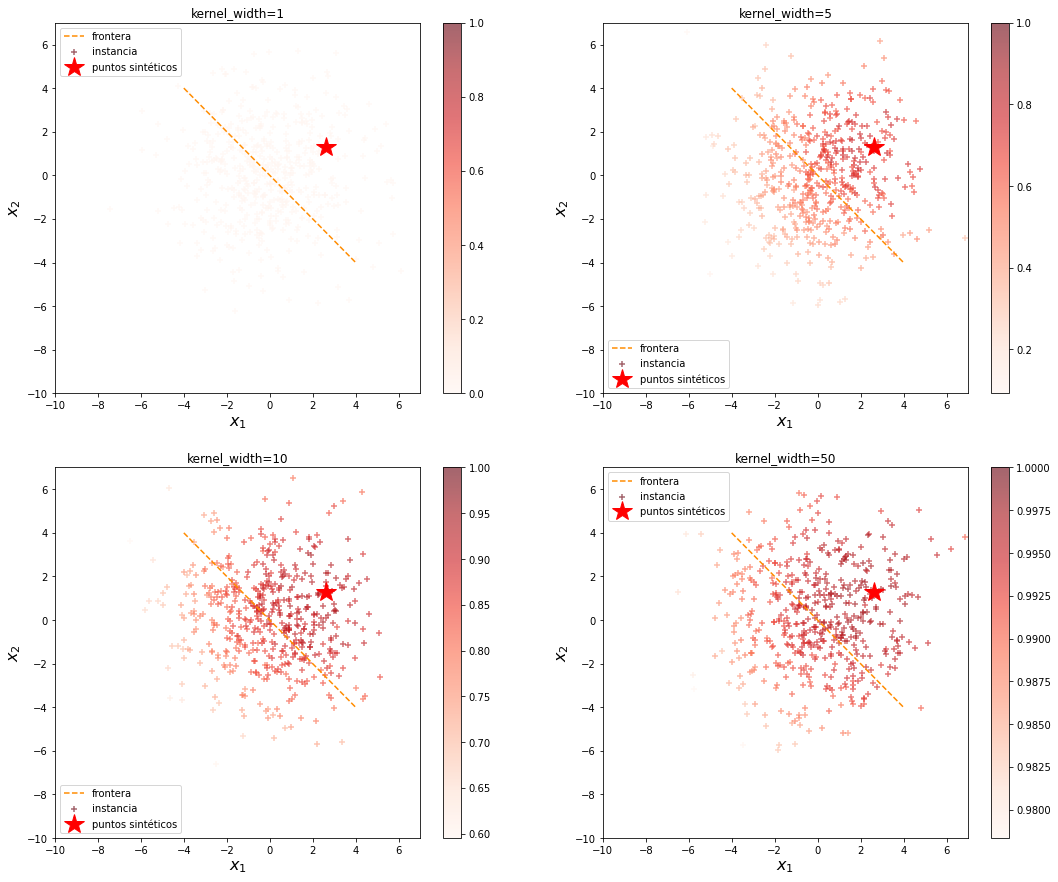

In [15]:
# Scatter del modelo continuo kernel_width = 1
plt.figure(figsize=(18, 15))
plt.subplot(2, 2, 1)
plt.plot([-4,4],[4,-4],linestyle='--',color='DarkOrange')
plt.scatter(inverse_1[:,0],inverse_1[:,1],alpha = 0.6,c=weights_1.ravel(),marker='+', facecolors='none', cmap='Reds')
plt.plot(X_test[id,0],X_test[id,1], color, markersize = 20,marker='*')
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$x_2$", fontsize=16)
plt.title('kernel_width=1')
plt.xlim(-10,7)
plt.ylim(-10,7)
plt.legend(['frontera','instancia','puntos sintéticos'])
plt.colorbar()

# Scatter del modelo continuo kernel_width = 5
plt.subplot(2, 2, 2)
plt.plot([-4,4],[4,-4],linestyle='--',color='DarkOrange')
plt.scatter(inverse_5[:,0],inverse_5[:,1],alpha = 0.6,c=weights_5.ravel(),marker='+', facecolors='none', cmap='Reds')
plt.plot(X_test[id,0],X_test[id,1], color, markersize = 20,marker='*')
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$x_2$", fontsize=16)
plt.title('kernel_width=5')
plt.xlim(-10,7)
plt.ylim(-10,7)
plt.legend(['frontera','instancia','puntos sintéticos'])
plt.colorbar()

# Scatter del modelo continuo kernel_width = 10
plt.subplot(2, 2, 3)
plt.plot([-4,4],[4,-4],linestyle='--',color='DarkOrange')
plt.scatter(inverse_10[:,0],inverse_10[:,1],alpha = 0.6,c=weights_10.ravel(),marker='+', facecolors='none', cmap='Reds')
plt.plot(X_test[id,0],X_test[id,1], color, markersize = 20,marker='*')
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$x_2$", fontsize=16)
plt.title('kernel_width=10')
plt.xlim(-10,7)
plt.ylim(-10,7)
plt.legend(['frontera','instancia','puntos sintéticos'])
plt.colorbar()

# Scatter del modelo continuo kernel_width = 50
plt.subplot(2, 2, 4)
plt.plot([-4,4],[4,-4],linestyle='--',color='DarkOrange')
plt.scatter(inverse_50[:,0],inverse_50[:,1],alpha = 0.6,c=weights_50.ravel(),marker='+', facecolors='none', cmap='Reds')
plt.plot(X_test[id,0],X_test[id,1], color, markersize = 20,marker='*')
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$x_2$", fontsize=16)
plt.title('kernel_width=50')
plt.xlim(-10,7)
plt.ylim(-10,7)
plt.colorbar()
plt.legend(['frontera','instancia','puntos sintéticos'])
plt.show()

Se puede apreciar con claridad la variación del efecto del kernel sobre el set de datos sintéticos generados. Cuando `kernel_width` es demasiado bajo, el *explainer* sólo considera la propia instancia para elaborar la explicación. Aumentando `kernel_width` conseguimos un mayor impacto de las puntos que rodean a la instancia a la hora de elaborar la explicación. Sin embargo, hay que tener cuidado. Cuando `kernel_width` es demasiado grande, todos los puntos son igualmente considerados. En este caso, la noción de localidad no se pierde y el modelo se ajusta globalmente a un entorno muy amplio de puntos.